In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [20]:
# CONFIGURACIÓN BÁSICA
# Ajusta esta ruta a donde tengas tu carpeta en la laptop
# Ejemplo: "C:/Users/TuUsuario/Datasets/ChestXRay/train"
# data_dir = r'C:/Users/Joshua Vallejo/OneDrive/Club de Inteligencia Artificial Politecnico/App Neumonia CIAP/chest_xray/train'
train_dir = r'D:/Jhon/tmp/archive/chest_xray/train'
val_dir = r'D:/Jhon/tmp/archive/chest_xray/val'
test_dir = r'D:/Jhon/tmp/archive/chest_xray/test'

batch_size = 32      # Cantidad de imágenes a procesar por lote
img_height = 180     # Redimensionaremos todas las imágenes a este tamaño
img_width = 180

In [14]:
# CARGA DEL DATASET
# Usamos esta función que es muy eficiente para cargar desde carpetas
print("Cargando set de entrenamiento...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True)

print("Cargando set de validación...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  label_mode='int',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = False)

# Imprimir las clases encontradas
class_names = train_ds.class_names
print(f"\nClases encontradas: {class_names}")

Cargando set de entrenamiento...
Found 5216 files belonging to 2 classes.
Cargando set de validación...
Found 16 files belonging to 2 classes.

Clases encontradas: ['NORMAL', 'PNEUMONIA']


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

# Optimización para el set de entrenamiento
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Optimización para el set de validación
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("¡Flujo de datos optimizado!")

num_classes = len(class_names) # Deberían ser 2 (Normal, Pneumonia)

¡Flujo de datos optimizado!


In [25]:
model = models.Sequential([
  # Capa 1: Normalización de entrada
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  # Bloque Convolucional 1
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Bloque Convolucional 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Bloque Convolucional 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  # Clasificación (Cerebro final)
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # Salida final (2 neuronas)
])

# COMPILACIÓN DEL MODELO
# Aquí definimos qué "optimizador" usará para aprender (Adam en este caso)
# y cómo medirá su error.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Ver resumen de la arquitectura
model.summary()

d:\Jhon\miniconda3\envs\SIC\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
import os

model_dir = "checkpoints/JOriginal"

# Create folder if it does not exist
os.makedirs(model_dir, exist_ok=True)

In [ ]:
epochs = 100

print(f"Iniciando entrenamiento por {epochs} épocas...")

# Guardamos la historia del entrenamiento para graficarla después
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

print("¡Entrenamiento finalizado!")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Guardamos el modelo en formato Keras nativo
model.save(model_dir+'/modelo_neumonia.keras')
print("¡Modelo guardado exitosamente como 'modelo_neumonia.keras'!")

Iniciando entrenamiento por 100 épocas...
Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 1.0000 - loss: 1.0559e-08 - val_accuracy: 1.0000 - val_loss: 2.1396e-04
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 1.0000 - loss: 9.8503e-09 - val_accuracy: 1.0000 - val_loss: 2.7354e-04
Epoch 3/100
 33/163 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 1.0000 - loss: 6.3740e-09

KeyboardInterrupt: 

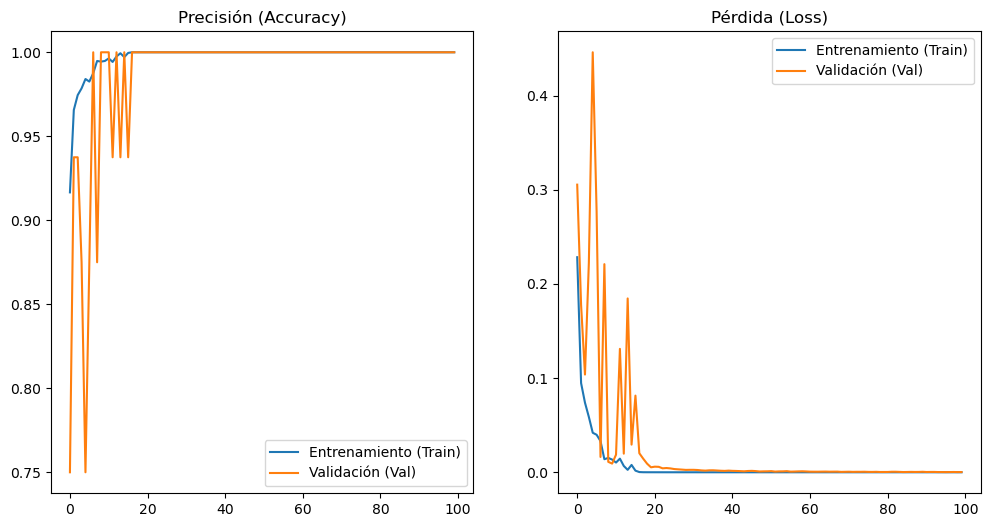

In [28]:
plt.figure(figsize=(12, 6))

# Gráfica de Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento (Train)')
plt.plot(epochs_range, val_acc, label='Validación (Val)')
plt.legend(loc='lower right')
plt.title('Precisión (Accuracy)')

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento (Train)')
plt.plot(epochs_range, val_loss, label='Validación (Val)')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss)')
plt.show()

# Test

In [29]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',   # or 'categorical' depending on your training
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False       # do NOT shuffle test set
)

Found 624 files belonging to 2 classes.


In [30]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3439 - loss: 18.5837

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7372 - loss: 8.0296 
Test accuracy: 0.7371794581413269
Test loss: 8.029579162597656
